# Importing Libraries

In [164]:
import pandas as pd
import numpy as np
import ast
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

import sklearn.utils as sk_util
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import f1_score


import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
from sklearn.naive_bayes import MultinomialNB

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn.metrics import classification_report
import string
import textblob
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import lightgbm as lgb

from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn import linear_model

import seaborn as sn
import matplotlib.pyplot as plt

# Importing the Dataset

## Reading the Data

In [2]:
data_train = pd.read_csv('hm_train.csv')
data_test = pd.read_csv('hm_test.csv')

In [3]:
data_train['predicted_category'].value_counts()

affection           20880
achievement         20274
bonding              6561
enjoy_the_moment     6508
leisure              4242
nature               1127
exercise              729
Name: predicted_category, dtype: int64

## Data Split into Train & Validation

In [4]:
x_train, x_val, y_train, y_val = train_test_split(data_train, data_train['predicted_category'],
                                                    random_state= 123, test_size = 0.2)

In [5]:
x_test = data_test.copy()

# Feature Engineering

## Feature Encoding

In [7]:
x_train['reflection_period_updt'] = x_train['reflection_period'].apply(lambda x: 1 if x =='24h' else 0)
x_val['reflection_period_updt'] = x_val['reflection_period'].apply(lambda x: 1 if x =='24h' else 0)
x_test['reflection_period_updt'] = x_test['reflection_period'].apply(lambda x: 1 if x =='24h' else 0)

C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Count Vectorizer

In [9]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words = 'english', 
                             min_df = 5, max_df = 0.9, ngram_range = (1,1))
count_vect.fit(x_train_full['cleaned_hm'].str.lower())

CountVectorizer(max_df=0.9, min_df=5, stop_words='english',
                token_pattern='\\w{1,}')

In [10]:
xtrain_count =  pd.DataFrame(count_vect.transform(x_train['cleaned_hm'].str.lower()).toarray())
xvalid_count =  pd.DataFrame(count_vect.transform(x_val['cleaned_hm'].str.lower()).toarray())
xtest_count =  pd.DataFrame(count_vect.transform(data_test['cleaned_hm'].str.lower()).toarray())

In [11]:
xtrain_count['reflection_period_updt'] =  x_train['reflection_period_updt'].values
xtrain_count['num_sentence'] =  x_train['num_sentence'].values

xvalid_count['reflection_period_updt'] =  x_val['reflection_period_updt'].values
xvalid_count['num_sentence'] =  x_val['num_sentence'].values

xtest_count['reflection_period_updt'] =  x_test['reflection_period_updt'].values
xtest_count['num_sentence'] =  x_test['num_sentence'].values

## TF-IDF Vectorizer

In [13]:
tf_idf_vec = TfidfVectorizer(analyzer= 'word', stop_words = 'english', ngram_range = (1,1), min_df = 3)
tf_idf_vec.fit(x_train_full['cleaned_hm'].str.lower())

TfidfVectorizer(min_df=3, stop_words='english')

In [14]:
xtrain_tf_idf =  pd.DataFrame(tf_idf_vec.transform(x_train['cleaned_hm'].str.lower()).toarray())
xvalid_tf_idf =  pd.DataFrame(tf_idf_vec.transform(x_val['cleaned_hm'].str.lower()).toarray())
xtest_tf_idf =  pd.DataFrame(tf_idf_vec.transform(x_test['cleaned_hm'].str.lower()).toarray())

In [15]:
xtrain_tf_idf['reflection_period_updt'] =  x_train['reflection_period_updt'].values
xtrain_tf_idf['num_sentence'] =  x_train['num_sentence'].values

xvalid_tf_idf['reflection_period_updt'] =  x_val['reflection_period_updt'].values
xvalid_tf_idf['num_sentence'] =  x_val['num_sentence'].values

xtest_tf_idf['reflection_period_updt'] =  x_test['reflection_period_updt'].values
xtest_tf_idf['num_sentence'] =  x_test['num_sentence'].values

## Universal Sentence Encoders

In [16]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

INFO:absl:Using C:\Users\mv15445\AppData\Local\Temp\tfhub_modules to cache modules.


In [19]:
xtrain_use = embed(x_train['cleaned_hm'].str.lower()).numpy()
xtrain_use = pd.DataFrame(data = xtrain_use, columns = [ 'USE_col_'+ str(ele) for ele in np.arange(1,512+1)])

xvalid_use = embed(x_val['cleaned_hm'].str.lower()).numpy()
xvalid_use = pd.DataFrame(data = xvalid_use, columns = [ 'USE_col_'+ str(ele) for ele in np.arange(1,512+1)])

xtest_use = embed(x_test['cleaned_hm'].str.lower()).numpy()
xtest_use = pd.DataFrame(data = xtest_use, columns = [ 'USE_col_'+ str(ele) for ele in np.arange(1,512+1)])

## Other Features

### Char & Word Count

In [20]:
xtrain_word_attr = pd.DataFrame()
xtrain_word_attr['char_count'] = x_train['cleaned_hm'].apply(len)
xtrain_word_attr['word_count'] = x_train['cleaned_hm'].apply(lambda x: len(x.split()))
xtrain_word_attr['word_density'] = xtrain_word_attr['char_count'] / (xtrain_word_attr['word_count']+1)
xtrain_word_attr['punctuation_count'] = x_train['cleaned_hm'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
xtrain_word_attr['title_word_count'] = x_train['cleaned_hm'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
xtrain_word_attr['upper_case_word_count'] = x_train['cleaned_hm'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
xtrain_word_attr.reset_index(drop=True, inplace=True)

In [21]:
xvalid_word_attr = pd.DataFrame()
xvalid_word_attr['char_count'] = x_val['cleaned_hm'].apply(len)
xvalid_word_attr['word_count'] = x_val['cleaned_hm'].apply(lambda x: len(x.split()))
xvalid_word_attr['word_density'] = xvalid_word_attr['char_count'] / (xvalid_word_attr['word_count']+1)
xvalid_word_attr['punctuation_count'] = x_val['cleaned_hm'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
xvalid_word_attr['title_word_count'] = x_val['cleaned_hm'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
xvalid_word_attr['upper_case_word_count'] = x_val['cleaned_hm'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
xvalid_word_attr.reset_index(drop=True, inplace=True)

In [22]:
xtest_word_attr = pd.DataFrame()
xtest_word_attr['char_count'] = x_test['cleaned_hm'].apply(len)
xtest_word_attr['word_count'] = x_test['cleaned_hm'].apply(lambda x: len(x.split()))
xtest_word_attr['word_density'] = xtest_word_attr['char_count'] / (xtest_word_attr['word_count']+1)
xtest_word_attr['punctuation_count'] = x_test['cleaned_hm'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
xtest_word_attr['title_word_count'] = x_test['cleaned_hm'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
xtest_word_attr['upper_case_word_count'] = x_test['cleaned_hm'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
xtest_word_attr.reset_index(drop=True, inplace=True)

### POS Tags

In [23]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

In [161]:
xtrain_word_attr2 = pd.DataFrame()
xtrain_word_attr2['noun_count'] = x_train['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'noun'))
xtrain_word_attr2['verb_count'] = x_train['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'verb'))
xtrain_word_attr2['adj_count'] = x_train['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'adj'))
xtrain_word_attr2['adv_count'] = x_train['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'adv'))
xtrain_word_attr2['pron_count'] = x_train['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'pron'))
xtrain_word_attr2.reset_index(drop=True, inplace=True)

In [162]:
xvalid_word_attr2 = pd.DataFrame()
xvalid_word_attr2['noun_count'] = x_val['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'noun'))
xvalid_word_attr2['verb_count'] = x_val['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'verb'))
xvalid_word_attr2['adj_count'] = x_val['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'adj'))
xvalid_word_attr2['adv_count'] = x_val['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'adv'))
xvalid_word_attr2['pron_count'] = x_val['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'pron'))
xvalid_word_attr2.reset_index(drop=True, inplace=True)

In [163]:
xtest_word_attr2 = pd.DataFrame()
xtest_word_attr2['noun_count'] = x_test['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'noun'))
xtest_word_attr2['verb_count'] = x_test['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'verb'))
xtest_word_attr2['adj_count'] = x_test['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'adj'))
xtest_word_attr2['adv_count'] = x_test['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'adv'))
xtest_word_attr2['pron_count'] = x_test['cleaned_hm'].apply(lambda x: check_pos_tag(x, 'pron'))
xtest_word_attr2.reset_index(drop=True, inplace=True)

# Model Training

In [24]:
results = pd.DataFrame(columns = ['Model', 'Type', 'Train F1 Score', 'Validation F1 Score'])

In [25]:
def func_model_train(model_name, feature, model, input_x, input_y, validation_x, validation_y, results):
    print("Model Training Started")
    model.fit(input_x, input_y)
    print("Model Training Completed")
    
    print("Model Scoring Started")
    y_pred_train = model.predict(input_x)
    y_pred_val = model.predict(validation_x)
    
    train_f1 = f1_score(input_y, y_pred_train, average='weighted')
    valid_f1 = f1_score(validation_y, y_pred_val, average='weighted')
    
    results = results.append(pd.Series([model_name, feature, train_f1, valid_f1], index= results.columns), ignore_index=True)  

#     results = results.append({'Model': model_name, 'Type': feature, 'Train F1 Score': train_f1, 'Validation F1 Score':valid_f1}, 
#                    ignore_index = True)
    
    print("Model Scoring Completed")
    
    print("Train F1 Score: ", train_f1)
    print("Validation F1 Score: ", valid_f1)
    
    return results

## Light GBM Classifier

### Tf-iDF Vectorizer

In [26]:
model = lgb.LGBMClassifier(class_weight='balanced', learning_rate = 0.5, colsample_bytree = 0.5, drop_rate=0.8, 
                           num_class = 7, objective = 'multiclass', metric = 'multi_logloss')

results = func_model_train('LightGBM', 'TF-IDF', model, xtrain_tf_idf, y_train, xvalid_tf_idf, y_val, results)

Model Training Started
Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9607474407484293
Validation F1 Score:  0.8770464012699706


### Count Vectorizer

In [27]:
model = lgb.LGBMClassifier(class_weight='balanced', learning_rate = 0.5, colsample_bytree = 0.5, drop_rate=0.8, 
                           num_class = 7, objective = 'multiclass', metric = 'multi_logloss')

results = func_model_train('LightGBM', 'Count Vectorizer', model, xtrain_count, y_train, xvalid_count, y_val, results)

Model Training Started
Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9382195297433588
Validation F1 Score:  0.8765049479795172


### Universal Sentence Encoder

In [28]:
model = lgb.LGBMClassifier(class_weight='balanced', learning_rate = 0.5, colsample_bytree = 0.5, drop_rate=0.8, 
                           num_class = 7, objective = 'multiclass', metric = 'multi_logloss')

results = func_model_train('LightGBM', 'USE', model, xtrain_use, y_train, xvalid_use, y_val, results)

Model Training Started
Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.999896397389126
Validation F1 Score:  0.8530666266200267


### USE + TF-IDF

In [29]:
model = lgb.LGBMClassifier(class_weight='balanced', learning_rate = 0.5, colsample_bytree = 0.5, drop_rate=0.8, 
                           num_class = 7, objective = 'multiclass', metric = 'multi_logloss')

results = func_model_train('LightGBM', 'USE + TF-IDF', model, pd.concat([xtrain_use, xtrain_tf_idf], axis = 1), y_train, 
                           pd.concat([xvalid_use, xvalid_tf_idf], axis = 1), y_val, results)

Model Training Started
Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9999585570703247
Validation F1 Score:  0.8728764197768201


### USE + Count Vectorizer

In [30]:
model = lgb.LGBMClassifier(class_weight='balanced', learning_rate = 0.5, colsample_bytree = 0.5, drop_rate=0.8, 
                           num_class = 7, objective = 'multiclass', metric = 'multi_logloss')

results = func_model_train('LightGBM', 'USE + Count', model, pd.concat([xtrain_use, xtrain_count], axis = 1), y_train, 
                           pd.concat([xvalid_use, xvalid_count], axis = 1), y_val, results)

Model Training Started
Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9999792778618507
Validation F1 Score:  0.8724972858741135


## Linear SVC

### Tf-iDF Vectorizer

In [31]:
model = LinearSVC(random_state=0, tol=1e-5)
results = func_model_train('LinearSVC', 'TF-IDF', model, xtrain_tf_idf, y_train, xvalid_tf_idf, y_val, results)

Model Training Started


C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9682157098729215
Validation F1 Score:  0.8970146366603484


### Count Vectorizer

In [32]:
model = LinearSVC(random_state=0, tol=1e-5)
results = func_model_train('LinearSVC', 'Count Vectorizer', model, xtrain_count, y_train, xvalid_count, y_val, results)

Model Training Started


C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9738432511884667
Validation F1 Score:  0.8938572994241286


### Universal Sentence Encoder

In [33]:
model = LinearSVC(random_state=0, tol=1e-5)
results = func_model_train('LinearSVC', 'USE', model, xtrain_use, y_train, xvalid_use, y_val, results)

Model Training Started
Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.8629654045927919
Validation F1 Score:  0.848233879197663


### USE + TF-IDF

In [34]:
model = LinearSVC(random_state=0, tol=1e-5)
results = func_model_train('LinearSVC', 'USE + TF-IDF', model, pd.concat([xtrain_use, xtrain_tf_idf], axis = 1), y_train, 
                           pd.concat([xvalid_use, xvalid_tf_idf], axis = 1), y_val, results)

Model Training Started


C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9792051807107466
Validation F1 Score:  0.9084761857659611


### USE + Count Vectorizer

In [35]:
model = LinearSVC(random_state=0, tol=1e-5)
results = func_model_train('LinearSVC', 'USE + Count', model, pd.concat([xtrain_use, xtrain_count], axis = 1), y_train, 
                           pd.concat([xvalid_use, xvalid_count], axis = 1), y_val, results)

Model Training Started


C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9853456498338229
Validation F1 Score:  0.9030041735579415


## Linear SGD

### Tf-iDF Vectorizer

In [36]:
model = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
results = func_model_train('LinearSGD', 'TF-IDF', model, xtrain_tf_idf, y_train, xvalid_tf_idf, y_val, results)

Model Training Started
Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.8950256009980248
Validation F1 Score:  0.869892468010589


### Count Vectorizer

In [37]:
model = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
results = func_model_train('LinearSGD', 'Count Vectorizer', model, xtrain_count, y_train, xvalid_count, y_val, results)

Model Training Started
Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9346337351925968
Validation F1 Score:  0.8907756649783208


### Universal Sentence Encoder

In [38]:
model = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
results = func_model_train('LinearSGD', 'USE', model, xtrain_use, y_train, xvalid_use, y_val, results)

Model Training Started
Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.8511038630155591
Validation F1 Score:  0.8424727696848661


### USE + TF-IDF

In [39]:
model = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
results = func_model_train('LinearSGD', 'USE + TF-IDF', model, pd.concat([xtrain_use, xtrain_tf_idf], axis = 1), y_train, 
                           pd.concat([xvalid_use, xvalid_tf_idf], axis = 1), y_val, results)

Model Training Started
Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9118994598669601
Validation F1 Score:  0.8826742246572282


### USE + Count Vectorizer

In [40]:
model = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
results = func_model_train('LinearSGD', 'USE + Count', model, pd.concat([xtrain_use, xtrain_count], axis = 1), y_train, 
                           pd.concat([xvalid_use, xvalid_count], axis = 1), y_val, results)

Model Training Started
Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.949743147346766
Validation F1 Score:  0.9030432608028438


## Log Reg

### Tf-iDF Vectorizer

In [126]:
model = LogisticRegression(random_state=0)
results = func_model_train('Log Reg', 'TF-IDF', model, xtrain_tf_idf, y_train, xvalid_tf_idf, y_val, results)

Model Training Started


C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9086761912729686
Validation F1 Score:  0.8813618413120164


### Count Vectorizer

In [127]:
model = LogisticRegression(random_state=0)
results = func_model_train('Log Reg', 'Count Vectorizer', model, xtrain_count, y_train, xvalid_count, y_val, results)

Model Training Started


C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9575454294805997
Validation F1 Score:  0.8980209549407122


### Universal Sentence Encoder

In [128]:
model = LogisticRegression(random_state=0)
results = func_model_train('Log Reg', 'USE', model, xtrain_use, y_train, xvalid_use, y_val, results)

Model Training Started


C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.859904134252248
Validation F1 Score:  0.8476464182720699


### USE + TF-IDF

In [129]:
model = LogisticRegression(random_state=0, max_iter = 300)
results = func_model_train('Log Reg', 'USE + TF-IDF', model, pd.concat([xtrain_use, xtrain_tf_idf], axis = 1), y_train, 
                           pd.concat([xvalid_use, xvalid_tf_idf], axis = 1), y_val, results)

Model Training Started


C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9406342025644168
Validation F1 Score:  0.8985854003420187


### USE + Count Vectorizer

In [130]:
model = LogisticRegression(random_state=0, max_iter = 300)
results = func_model_train('Log Reg', 'USE + Count', model, pd.concat([xtrain_use, xtrain_count], axis = 1), y_train, 
                           pd.concat([xvalid_use, xvalid_count], axis = 1), y_val, results)

Model Training Started


C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Training Completed
Model Scoring Started
Model Scoring Completed
Train F1 Score:  0.9731991874923045
Validation F1 Score:  0.9114207550913065


# Results

## Performance Comparison

###### Best Performance: Model - Logistic Regression + Featurization Used: Universal Sentence Encoders & CountVectorizer

In [165]:
results

,Model,Type,Train F1 Score,Validation F1 Score
0,LightGBM,TF-IDF,0.960747,0.877046
1,LightGBM,Count Vectorizer,0.938220,0.876505
2,LightGBM,USE,0.999896,0.853067
3,LightGBM,USE + TF-IDF,0.999959,0.872876
4,LightGBM,USE + Count,0.999979,0.872497
5,LinearSVC,TF-IDF,0.968216,0.897015
6,LinearSVC,Count Vectorizer,0.973843,0.893857
7,LinearSVC,USE,0.862965,0.848234
8,LinearSVC,USE + TF-IDF,0.979205,0.908476
9,LinearSVC,USE + Count,0.985346,0.903004


## Best Model Execution

In [82]:
model = LogisticRegression(random_state=0, max_iter = 300)
model.fit(pd.concat([xtrain_use, xtrain_count], axis = 1), y_train)

C:\Users\mv15445\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(max_iter=300, random_state=0)

In [131]:
import pickle
Pkl_Filename = "best_model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

## Performance Stats

### Weighted F1-Score

In [83]:
y_pred_train = model.predict(pd.concat([xtrain_use, xtrain_count], axis = 1)) 
print("Training Score ", f1_score(y_train, y_pred_train, average='weighted'))

y_pred_val = model.predict(pd.concat([xvalid_use, xvalid_count], axis = 1))
print("Validation Score ", f1_score(y_val, y_pred_val, average='weighted'))

Training Score  0.9731991874923045
Validation Score  0.9114207550913065


### Confusion Matrix

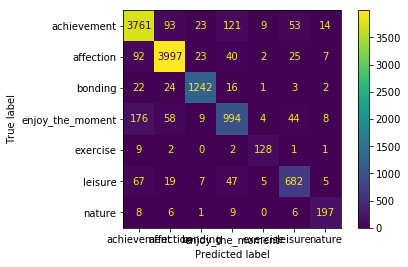

In [84]:
plot_confusion_matrix(model, pd.concat([xvalid_use, xvalid_count], axis = 1), y_val)

### Classification Report

In [93]:
print(classification_report(y_val, y_pred_val))

                  precision    recall  f1-score   support

     achievement       0.91      0.92      0.92      4074
       affection       0.95      0.95      0.95      4186
         bonding       0.95      0.95      0.95      1310
enjoy_the_moment       0.81      0.77      0.79      1293
        exercise       0.86      0.90      0.88       143
         leisure       0.84      0.82      0.83       832
          nature       0.84      0.87      0.85       227

        accuracy                           0.91     12065
       macro avg       0.88      0.88      0.88     12065
    weighted avg       0.91      0.91      0.91     12065



### Top Features

In [133]:
coef = pd.DataFrame(model.coef_)

In [144]:
coef.columns = xtrain_use.columns.tolist() + count_vect.get_feature_names() + ['reflection_period_updt', 'num_sentence']

In [148]:
coef['label'] = model.classes_

In [151]:
coef_melt = pd.melt(coef, id_vars =['label'], var_name='feature', value_name='coef_value')

In [153]:
coef_melt.sort_values(by= 'coef_value', ascending = False, inplace = True)

###### Top Feature for each class are idenitfied to validate the results based on the coefficient values. Example: Top 5 Features for:   
- Affection: are Wife, Husband, Family, Daughter & Boyfriend
- Achievement: are Won, Exam, Encoder Feature (USE), Company & Job

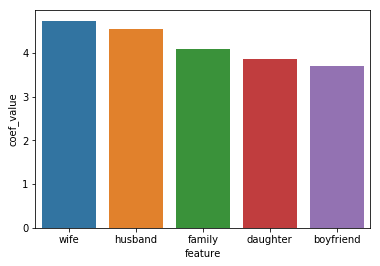

In [166]:
sn.barplot(x="feature",y="coef_value",data=coef_melt[coef_melt['label'] == 'affection'].head(5))

In [158]:
coef_melt[coef_melt['label'] == 'affection'].head(10)

,label,feature,coef_value
49190,affection,wife,4.739987
24501,affection,husband,4.551634
19405,affection,family,4.096631
14995,affection,daughter,3.870174
9241,affection,boyfriend,3.705570
3249,affection,USE_col_465,3.636583
9619,affection,brother,3.570001
42085,affection,son,3.492087
21806,affection,girlfriend,3.490138
30360,affection,mom,3.201862


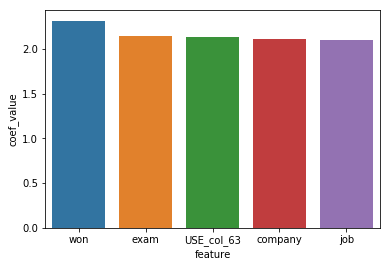

In [167]:
sn.barplot(x="feature",y="coef_value",data=coef_melt[coef_melt['label'] == 'achievement'].head(5))

In [160]:
coef_melt[coef_melt['label'] == 'achievement'].head(10)

,label,feature,coef_value
49462,achievement,won,2.312329
18641,achievement,exam,2.141681
434,achievement,USE_col_63,2.134023
12859,achievement,company,2.105872
26194,achievement,job,2.094958
27258,achievement,laws,2.059403
13055,achievement,computer,2.044663
12026,achievement,cleaned,1.963245
1967,achievement,USE_col_282,1.930794
47425,achievement,university,1.807057


## Submission File

In [168]:
submission_file = pd.DataFrame()

In [171]:
submission_file['hmid'] = data_test['hmid']
submission_file['predicted_category'] = y_pred_test

In [172]:
submission_file.to_csv('submission_file.csv', index = False)